<a href="https://colab.research.google.com/github/antahiap/dsr-nlp/blob/main/notebooks/01_MINST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Runtime setting for T4

In [1]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

In [5]:
(dataset_train_original, dataset_validation_original, dataset_test_original), info = tfds.load(    # unonomus variable
            "mnist",
            split=["train", "test[:50%]",  "test[50%:]"],
            as_supervised=True, # not activeated, the data will be as dict, now as tuple
            with_info =True    #
)
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

- how many data per claas for "training" a DL, 10k and transfer learning around 1k (deppending on the model)
- if little data, skip validation and keep test, validation leak into the training
- test set to evalute how good model perform on unseen data and not overfit to seen data
- validation, use during training to evaluate the performance of the model during the training and save the best model.
- kfault cross validation and data leakage is not a problem with LLMs
- good aplit, 70,10, 20, train-valid-test.
- if don't randomize the train data, shuffle, we will overfit on the order of the data
- `.take` with shuffle goes with uniform probability selection, without is just the first ones
- `.shuffle` increasing the number will make it to break due to error, try to maximize as long as the memory don't collapse

In [13]:
!nvidia-smi

Mon Aug  7 10:24:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

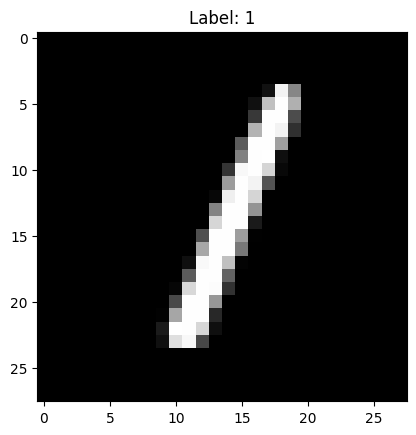

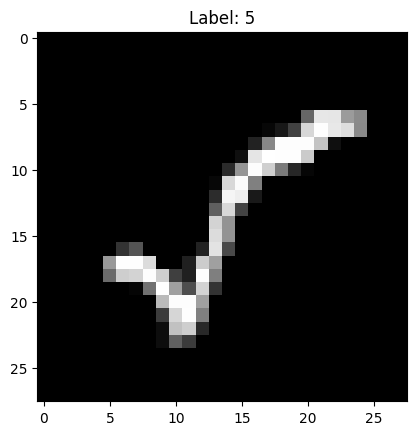

In [10]:
for x, y in dataset_train_original.shuffle(6000).take(2): # Chaining pattern
  plt.imshow(x, cmap="gray") # "inferno")
  plt.title(f"Label: {y}")
  plt.show()

- minibatch-GD, good to smoothen the loss curve, keep power 2, due to better distribution
- including all, will too smooth the loss curve
